In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

# Set options for better readability of numbers
%precision 4

'%.4f'

# PCA

PCA aims to reduce dimensions by eliminating useless (or least useful) features.
If the features are correlated, keeping one or the other may lead to misleading conclusions. Thus, instead of keeping certain features, we can transform the data into a new space where the features are uncorrelated and preserve the variation in the data.

For a very nice illustration and discussion, see [this Cross Validated post](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues).

## Illustration of PCA on a simple simulated dataset with 2 correlated features

### Technical detour: best practice for pseudo random number generation and ensuring reproducibility

Ensuring reproducibility by setting the global seed with `np.random.seed()` is a risky practice as it modifies the global state. Some imported packages and functions may be unintentionally affected.

The recommended practice instead is to create a new (psuedo) random number generator and pass it around.
Call `np.random.RandomState(<seed>)` to create a new RNG. This can be either used to create random numbers directly, or added as an argument to a function that requires a random state (e.g. sklearn functions).

See more details [here](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

In [19]:
prng = np.random.RandomState(20250303)

In [4]:
# [HELPER FUNCTIONS] Generate correlated features
def generateRandomCovarianceVarianceMatrix(n_features, prng=None):
    if prng is None:
        prng = np.random.RandomState()

    random_matrix = prng.rand(n_features, n_features)
    
    # Construct a symmetric positive definite matrix
    var_cov_matrix = np.dot(random_matrix, random_matrix.T)
    
    # Normalize diagonal to ensure reasonable variances
    diag = np.sqrt(np.diag(var_cov_matrix))
    var_cov_matrix = var_cov_matrix / np.outer(diag, diag)  # Correlation-like structure

    # Ensure unit variance by dividing by diagonal elements
    var_cov_matrix = var_cov_matrix / np.diag(var_cov_matrix)[:, np.newaxis]
    
    return var_cov_matrix
    
def generateCorrelatedFeatures(n_features, n_samples, vc_matrix=None, prng=None):
    if prng is None:
        prng = np.random.RandomState()

    if vc_matrix is None:
        vc_matrix = generateRandomCovarianceVarianceMatrix(n_features, prng)
        
    data = prng.multivariate_normal(np.repeat(0, n_features), vc_matrix, size=n_samples)
    return pd.DataFrame(data, columns=[f'Feature {i+1}' for i in range(n_features)]) # work with Pandas DataFrames

### Data generation (2 features)

In [20]:
# Generate data
n_samples = 100
n_features = 2
X = generateCorrelatedFeatures(n_features, n_samples, prng=prng)

In [21]:
np.cov(X, rowvar=False)

array([[1.2435, 0.998 ],
       [0.998 , 1.0459]])

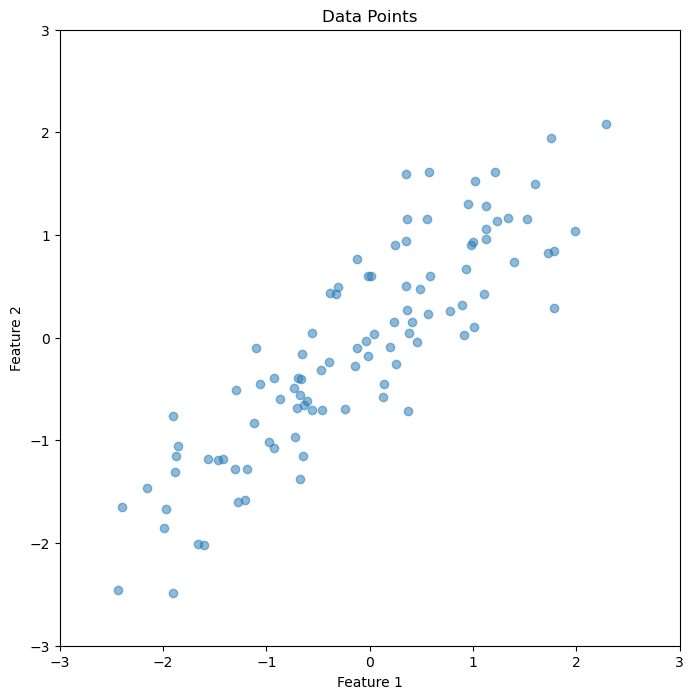

In [22]:
# Plot the original data
plt.figure(figsize=(8, 8))

plt.scatter(X["Feature 1"], X["Feature 2"], alpha=0.5)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Data Points")

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.show()

### Motivating PCA: projection of data onto a line

In [23]:
# [HELPER FUNCTIONS] Create plot with points projected to a certain direction
def plotDataWithProjection(direction_vector, X):
    direction = direction_vector / np.linalg.norm(direction_vector)  # normalize to unit vector
    
    # Plot original data points
    plt.scatter(X["Feature 1"], X["Feature 2"], alpha=0.5, label='Original points')

    # Draw the direction vector as a line across the chart
    plt.plot(
        [-5 * direction[0], 5 * direction[0]], [-5 * direction[1], 5 * direction[1]], 
        color='darkred', alpha=0.5, label='Projection direction'
    )

    # Calculate projections
    X_array = X.values
    projections = np.outer(X_array @ direction, direction)

    # Plot projection points and lines
    plt.scatter(projections[:, 0], projections[:, 1], color='darkred', alpha=0.5, label='Projected points')

    # Draw lines between original points and their projections
    for i in range(len(X)):
        plt.plot([X_array[i, 0], projections[i, 0]], [X_array[i, 1], projections[i, 1]], color='darkred', alpha=0.2)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Data Points with Projections')
    plt.legend()

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)



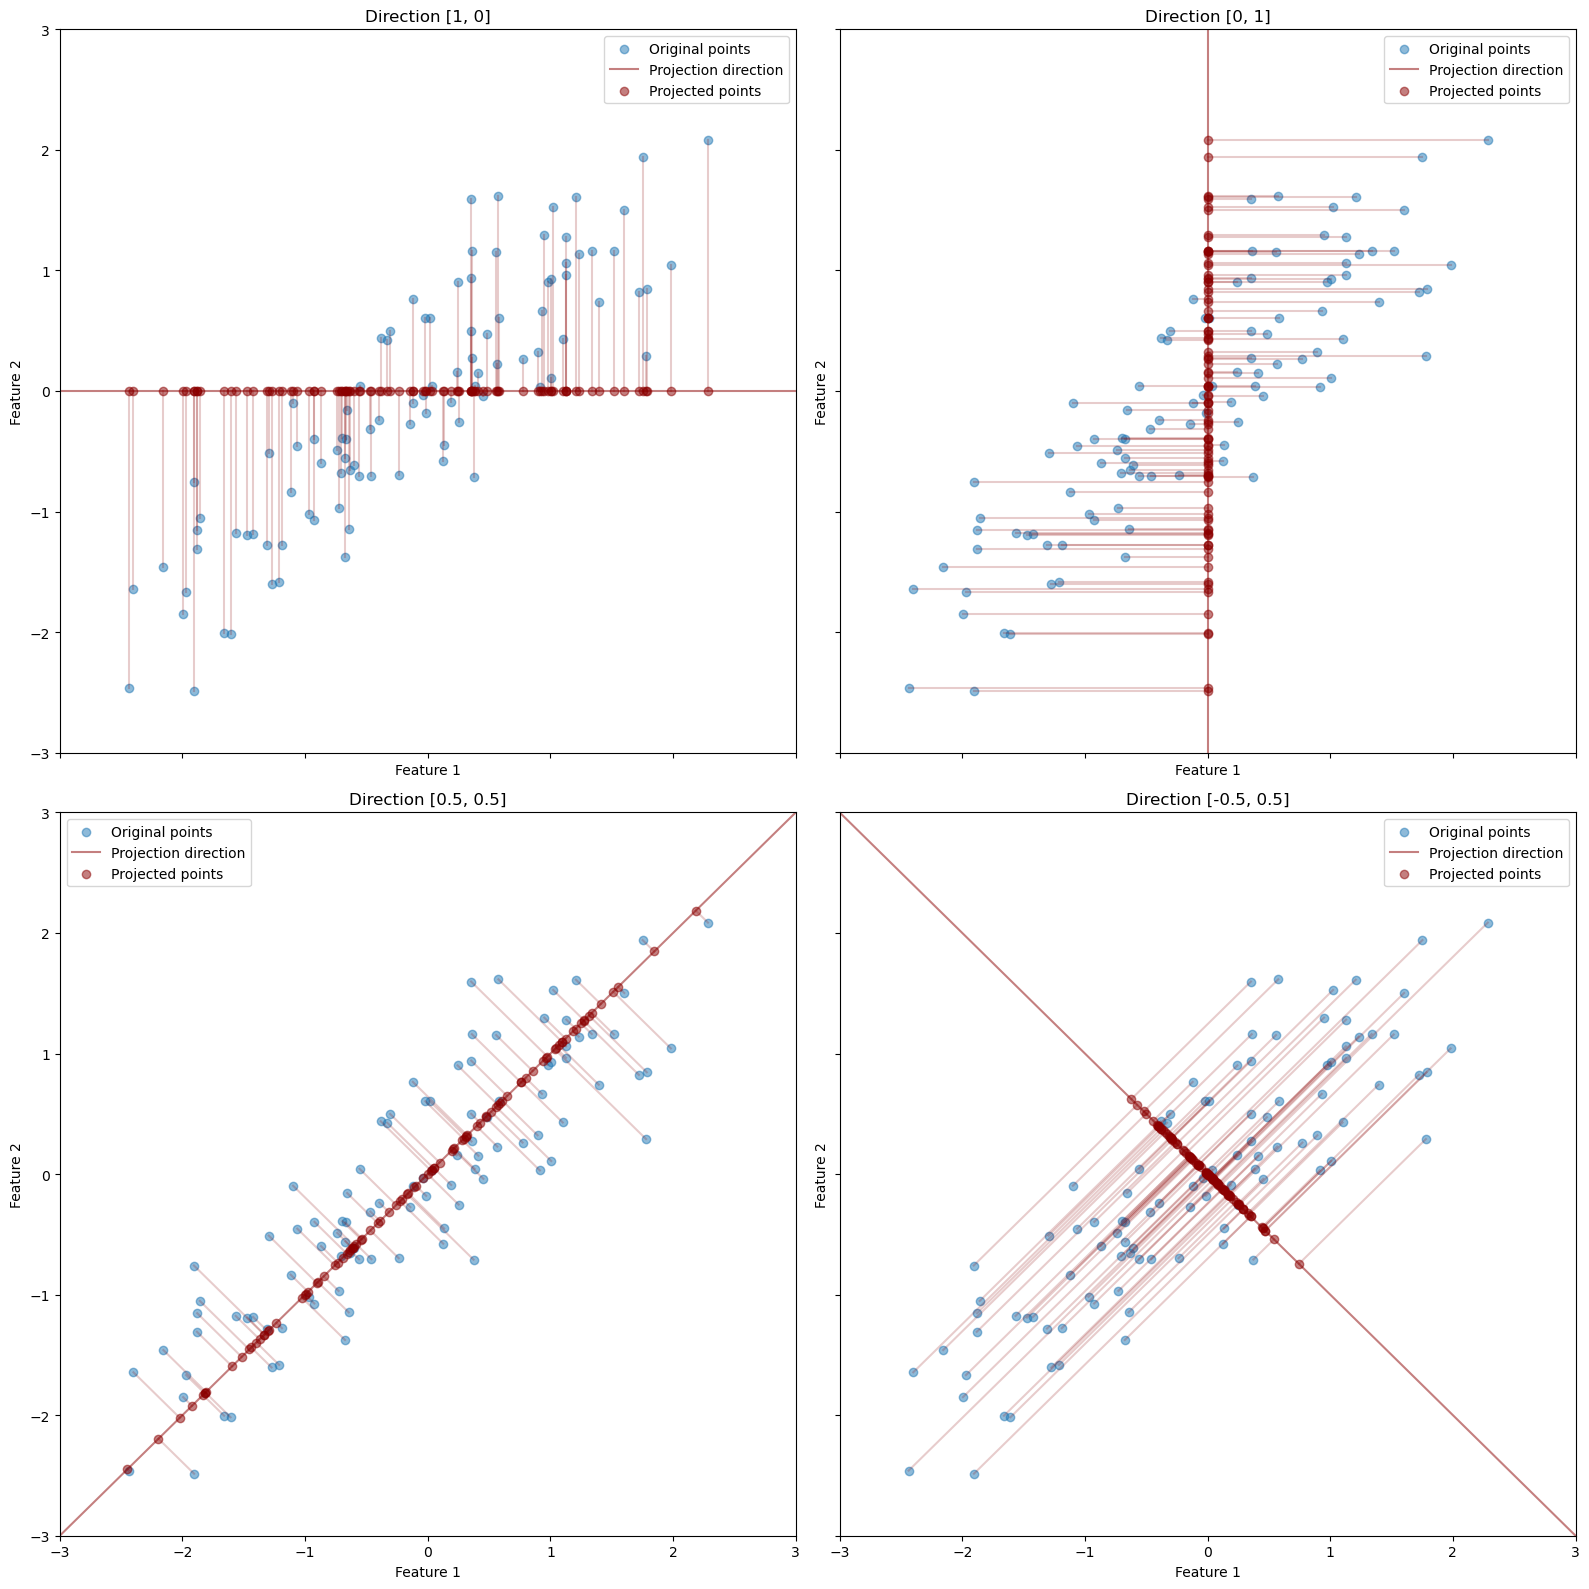

In [24]:
# Create a 2x2 grid of plots with different direction vectors
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 16))

# Store current axis to restore later
current_ax = plt.gca()

# Plot with different direction vectors
plt.sca(ax1)
plotDataWithProjection([1, 0], X)
ax1.set_title("Direction [1, 0]")

plt.sca(ax2) 
plotDataWithProjection([0, 1], X)
ax2.set_title("Direction [0, 1]")

plt.sca(ax3)
plotDataWithProjection([0.5, 0.5], X)
ax3.set_title("Direction [0.5, 0.5]")

plt.sca(ax4)
plotDataWithProjection([-0.5, 0.5], X)
ax4.set_title("Direction [-0.5, 0.5]")

plt.tight_layout()

# Restore the axis for subsequent plots
plt.sca(current_ax)

### Running PCA on a simple example of 2 features

#### Technical detour: working of sklearn models

In [25]:
# Apply PCA and calculate the principal components as X_pca
pca = PCA() #definition of the model
pca

PCA()

In [26]:
pca.components_

AttributeError: 'PCA' object has no attribute 'components_'

In [27]:
pca.fit(X)

PCA()

In [28]:
pca.components_

array([[ 0.7411,  0.6714],
       [-0.6714,  0.7411]])

In [29]:
X_pca = pca.transform(X)

# You can also use fit_transform() to fit the model and transform the data at the same time
X_pca = pca.fit_transform(X)

Note that the result is a numpy array, not a DataFrame.

In [ ]:
print("Type of X: ", type(X))
print("Type of X_pca: ", type(X_pca))

*Question:* Why don’t we set a random state for the PCA model? Will the results be reproducible?

<details>
<summary>Answer</summary>
    
PCA is a deterministic algorithm, so the results are reproducible regardless of the random state.

The only difference that could be observed is the difference in the sign of the principal components, which is not important.
</details>

#### Check characteristics of PCA

Recap: We transform the coordinates of the original variables to capture as much variation as we can with independent (orthogonal) dimensions.



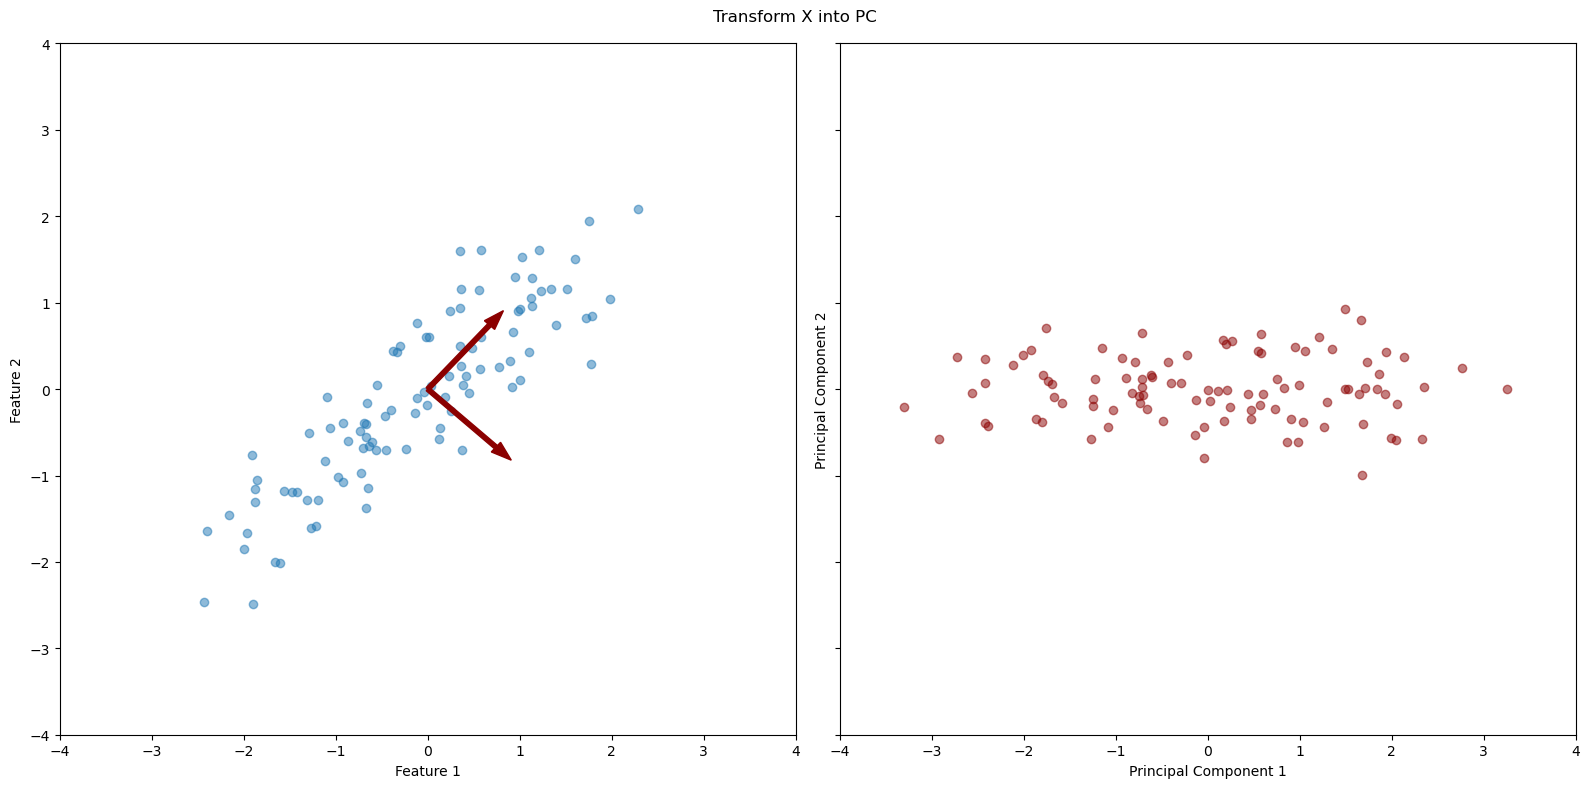

In [30]:
# Compare the space of X to the space of principal components
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 8))
    
fig.suptitle('Transform X into PC')

ax1.scatter(X["Feature 1"], X["Feature 2"], alpha=0.5)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)

# add the principal component transformation vectors to the plot once you know where to get the loadings from
ax1.arrow(0, 0, pca.components_[0, 0], pca.components_[1, 0], color='darkred', width=0.05)
ax1.arrow(0, 0, pca.components_[0, 1], pca.components_[1, 1], color='darkred', width=0.05)

# add a new plot about the transformed features
ax2.scatter(X_pca[:, 0], X_pca[:, 1], color='darkred', alpha=0.5)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)

fig.tight_layout()


##### Explained variance

In [33]:
np.var(X, axis=0)

Feature 1    1.231037
Feature 2    1.035443
dtype: float64

In [31]:
total_variance = np.var(X, axis=0).sum()
total_variance

2.2665

In [32]:
pca.explained_variance_

array([2.1476, 0.1418])

In [34]:
pca.explained_variance_ratio_

array([0.9381, 0.0619])

In [35]:
print(f'The first principal component explains {round(pca.explained_variance_ratio_[0] * 100, 1)}% of the total variance')

The first principal component explains 93.8% of the total variance


##### Loadings/weights: how to transform the space of X into the space of principal components

In [36]:
pca.components_

array([[ 0.7411,  0.6714],
       [-0.6714,  0.7411]])

Text(0.5, 1.0, 'PCA Components Loadings')

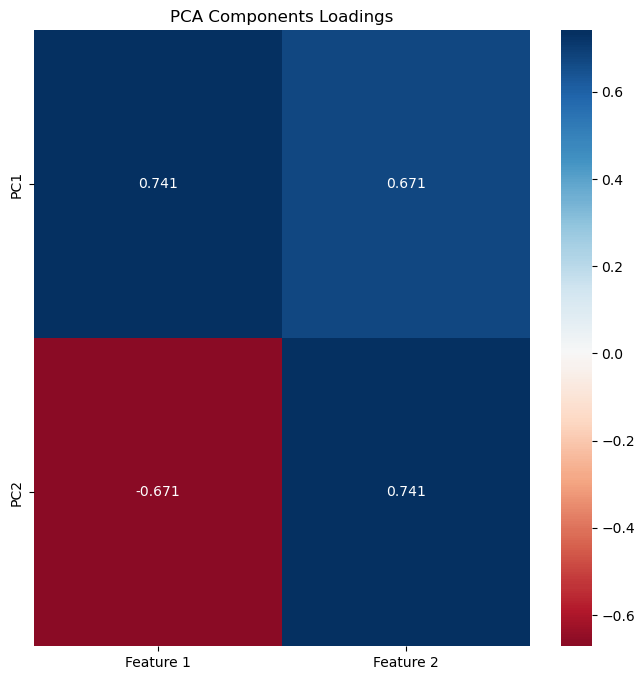

In [37]:
# Visualize the loadings
plt.figure(figsize=(8, 8))
sns.heatmap(
    pca.components_, 
    cmap='RdBu', center=0, annot=True, fmt='.3f', 
    xticklabels=['Feature 1', 'Feature 2'], yticklabels=['PC1', 'PC2']
)
plt.title('PCA Components Loadings')


##### Orthogonality of principal components

Each principal component contains "independent" variance from the data:

In [38]:
sum(pca.components_[:, 0] * pca.components_[:, 1])

0.0000

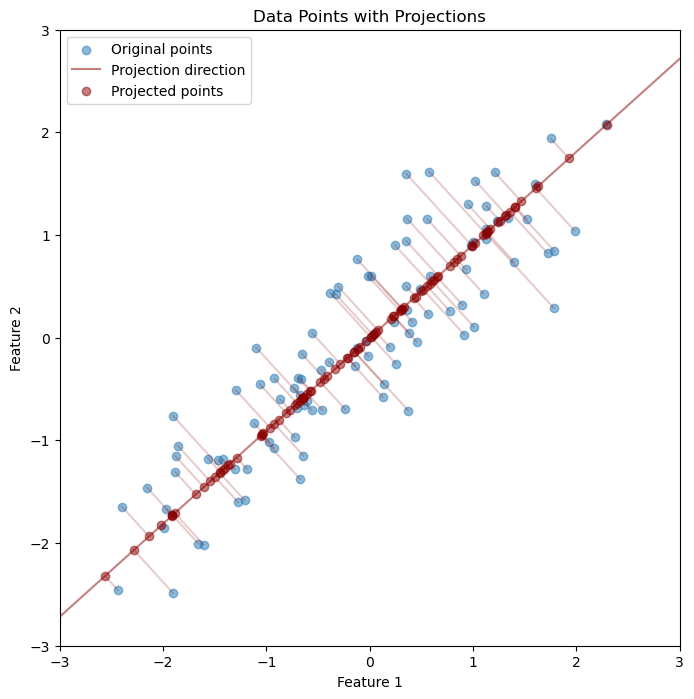

In [39]:
plt.figure(figsize=(8, 8))
plotDataWithProjection(pca.components_[0], X)

##### Reconstruction error using only the first principal component


In [40]:
pca1 = PCA(n_components=1)
X_pca1 = pca1.fit_transform(X)

In [42]:
pca1.components_

array([[0.7411, 0.6714]])

In [45]:
X_pca1.shape

(100, 1)

In [41]:
# Double-check that PC1 of the original PCA modell is the same
for i in range(5):
    print(X_pca[i, 0], X_pca1[i][0])

1.297562081299427 1.297562081299427
0.5840773484492965 0.5840773484492965
-0.43177158932625137 -0.43177158932625137
1.644183567685777 1.644183567685777
-0.7178822669250151 -0.7178822669250151


In [50]:
reconstructed_data = pca1.inverse_transform(X_pca1)
reconstructed_data.shape

(100, 2)

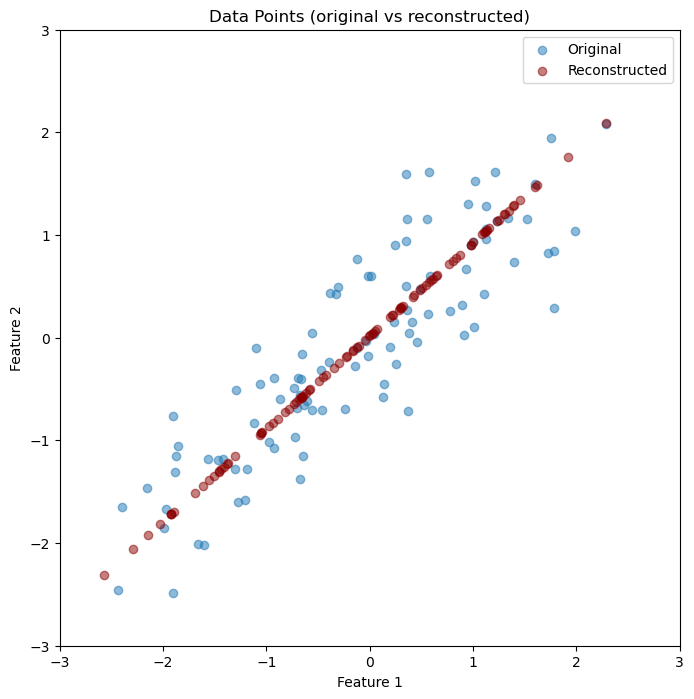

In [51]:
# Plot the original data and the reconstructed data
plt.figure(figsize=(8, 8))

plt.scatter(X["Feature 1"], X["Feature 2"], alpha=0.5, label="Original")
plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.5, color="darkred", label="Reconstructed")

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Data Points (original vs reconstructed)")
plt.legend()
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.show()

In [52]:
# Calculate reconstruction error (average squared distance = variance not explained)
def calculateReconstructionError(X, X_reconstructed):
    return np.mean(np.sum(np.square(X - X_reconstructed), axis=1))

reconstruction_error = calculateReconstructionError(X, reconstructed_data)
reconstruction_error

0.1404

In [53]:
reconstruction_error / total_variance

0.0619

### Generalization

In [54]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.3, random_state=prng)

# Fit PCA on training data
pca_train = PCA(n_components=1)
X_train_pca = pca_train.fit_transform(X_train)

# Transform test data using PCA fit on training data
X_test_pca = pca_train.transform(X_test)

# Reconstruct test data
X_test_reconstructed = pca_train.inverse_transform(X_test_pca)


In [55]:
print("Original dimension of the test data: ", X_test.shape)
print("Transformed dimension of the test data (dimensionality reduction): ", X_test_pca.shape)
print("Reconstructed dimension of the test data: ", X_test_reconstructed.shape)

Original dimension of the test data:  (30, 2)
Transformed dimension of the test data (dimensionality reduction):  (30, 1)
Reconstructed dimension of the test data:  (30, 2)


In [56]:
# Calculate reconstruction errors on test and train sets
test_reconstruction_error = calculateReconstructionError(X_test, X_test_reconstructed)

X_train_reconstructed = pca_train.inverse_transform(X_train_pca)
train_reconstruction_error = calculateReconstructionError(X_train, X_train_reconstructed)

print(f"Train set reconstruction error: {train_reconstruction_error:.4f}")
print(f"Test set reconstruction error: {test_reconstruction_error:.4f}")

Train set reconstruction error: 0.1372
Test set reconstruction error: 0.1508


### Relation to OLS

In [57]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression().fit(X[["Feature 1"]], X["Feature 2"])

#### Technical detour: Series vs DataFrame

In [ ]:
print(f"Single brackets create a Series, not a DataFrame: {type(X["Feature 1"])}")
print(f"Double brackets create a DataFrame with one column: {type(X[["Feature 1"]])}")

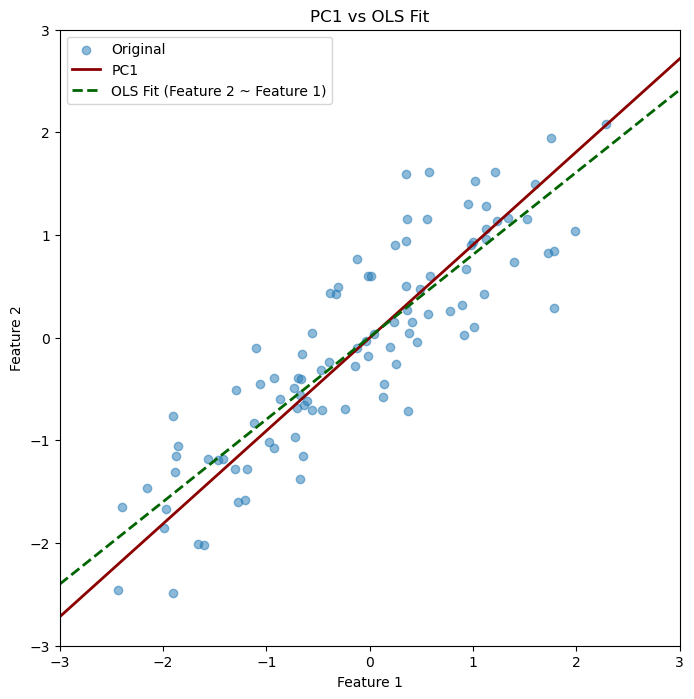

In [58]:
# Plot the original data, the first principal component direction, and the OLS fit
plt.figure(figsize=(8, 8))

# Original data points
plt.scatter(X["Feature 1"], X["Feature 2"], alpha=0.5, label="Original")

# Plot a line along the PC1 direction
x_line = np.array([-3, 3])
y_line = (pca1.components_[0][1] / pca1.components_[0][0]) * x_line
plt.plot(x_line, y_line, color="darkred", linewidth=2, label="PC1")

# OLS fit of Feature 2 on Feature 1
y_ols = ols.intercept_ + ols.coef_ * x_line
plt.plot(x_line, y_ols, '--', color="darkgreen", linewidth=2, label="OLS Fit (Feature 2 ~ Feature 1)")

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("PC1 vs OLS Fit")
plt.legend()
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.show()

- PCA minimizes the sum of squared **perpendicular** distances from each point to the principal component line (treates both features symmetrically)
- OLS minimizes the sum of squared **vertical** distances from each point to the regression line (treates features asymmetrically: predictor vs target)

## Running PCA on a larger dataset

In [59]:
# Generate data
n_samples = 100
n_features = 50
X_large = pd.DataFrame(prng.multivariate_normal(mean=np.repeat(0, n_features), cov=np.eye(n_features), size=n_samples))

In [60]:
# The data is indeed large, hard to visualize
X_large.shape

(100, 50)

**TODO**: 
- create a PCA model
- train with the large dataset
- check the explained variance ratio for each component
- How many components do we need to explain at least 90% of the total variance?

In [64]:
# solution
pca_large = PCA()
pca_large.fit(X_large)
cumulative_variance = np.cumsum(pca_large.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components needed to explain at least 90% variance: {n_components_90}")

Number of components needed to explain at least 90% variance: 34


In [67]:
# reconstruction error based on the first n_components_90 principal components
pca_large_90 = PCA(n_components=n_components_90) # definition of the model
pca_large_90.fit(X_large) # training of the model

X_large_reconstructed_90 = pca_large_90.inverse_transform(pca_large_90.transform(X_large))

# Calculate reconstruction error (RMSE)   
reconstruction_error = calculateReconstructionError(X_large, X_large_reconstructed_90)
reconstruction_error

4.5214

In [68]:
total_variance_large = np.var(X_large, axis=0).sum()
total_variance_large

48.5793

In [69]:
reconstruction_error / total_variance_large

0.0931

### Generalization

**TODO**:
- split the data into train (70%) and test (30%) set
- create a PCA model with the number of components we identified above
- fit the model on the train data
- calculate the reconstruction error for both the train and the test data

In [73]:
# solution

# Split data into train and test sets
X_large_train, X_large_test = train_test_split(X_large, test_size=0.3, random_state=prng)

# Fit PCA on training data
X_large_train_pca = pca_large_90.fit_transform(X_large_train)

# Transform test data using PCA fit on training data
X_large_test_pca = pca_large_90.transform(X_large_test)

# Reconstruct and calculate reconstruction errors
X_large_train_reconstructed = pca_large_90.inverse_transform(X_large_train_pca)
train_large_reconstruction_error = calculateReconstructionError(X_large_train, X_large_train_reconstructed)

X_large_test_reconstructed = pca_large_90.inverse_transform(X_large_test_pca)
test_large_reconstruction_error = calculateReconstructionError(X_large_test, X_large_test_reconstructed)

print(f"Train set reconstruction error: {train_large_reconstruction_error:.4f}")
print(f"Test set reconstruction error: {test_large_reconstruction_error:.4f}")

Train set reconstruction error: 2.8210
Test set reconstruction error: 16.9107


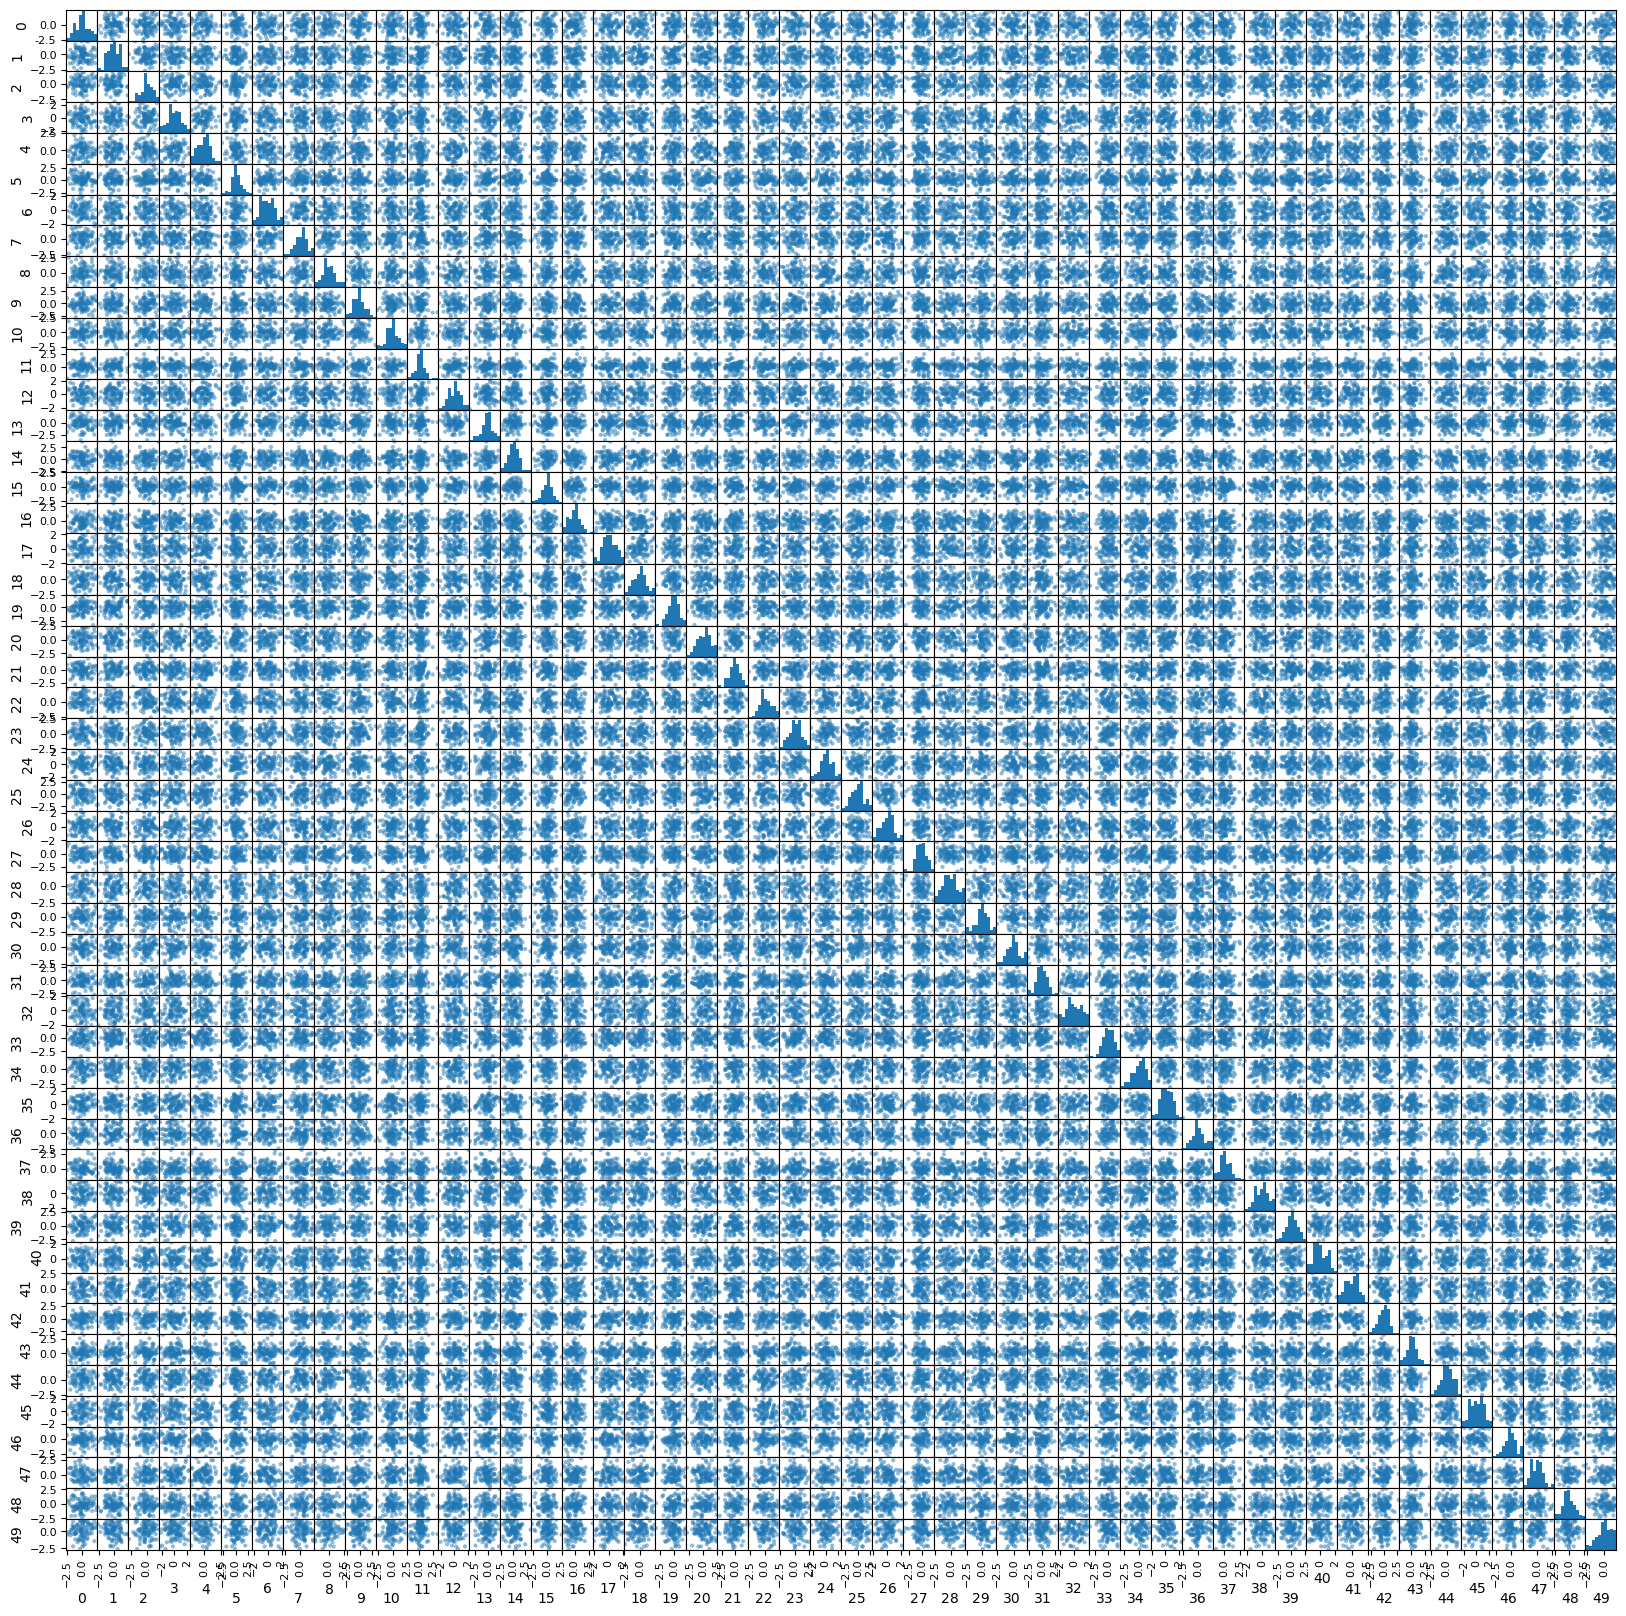

In [72]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

scatter_matrix(X_large, figsize=(20, 20), diagonal='hist')  # 'hist' for histograms on the diagonal
plt.show()


**Lessons:**

- If the original data set consists of independent predictors with equal variance, PCA cannot reduce its dimensionality without losing a proportional amount of information.
- PCA can overfit to noise, similar to standard supervised learning algorithms. Splitting data into training and test sets, then comparing reconstruction errors between them, can help detect such overfitting.
